Running 50 simulations for each distribution and budget...
  ...run 10/50
  ...run 20/50
  ...run 30/50
  ...run 40/50
  ...run 50/50

--- Average Mean Squared Error vs. Budget ---

--- Distribution: uniform ---
            Uniform      Thompson  Baharav et al. (Alg 1)
500    2.048649e-07  1.631005e-02            2.156460e-07
1000   4.089172e-07  2.355177e-03            4.742587e-07
2500   6.548513e-07  9.372318e-05            5.587356e-07
5000   4.242140e-07  4.484833e-11            1.441020e-07
7500   3.102819e-07  7.519131e-12            1.435756e-09
10000  1.805985e-07  2.636962e-13            1.225114e-10

--- Distribution: hard_outlier ---
        Uniform  Thompson  Baharav et al. (Alg 1)
500    0.000012  0.001183                0.000012
1000   0.000012  0.000044                0.000013
2500   0.000013  0.000007                0.000009
5000   0.000013  0.000005                0.000005
7500   0.000013  0.000005                0.000004
10000  0.000013  0.000002                0.000

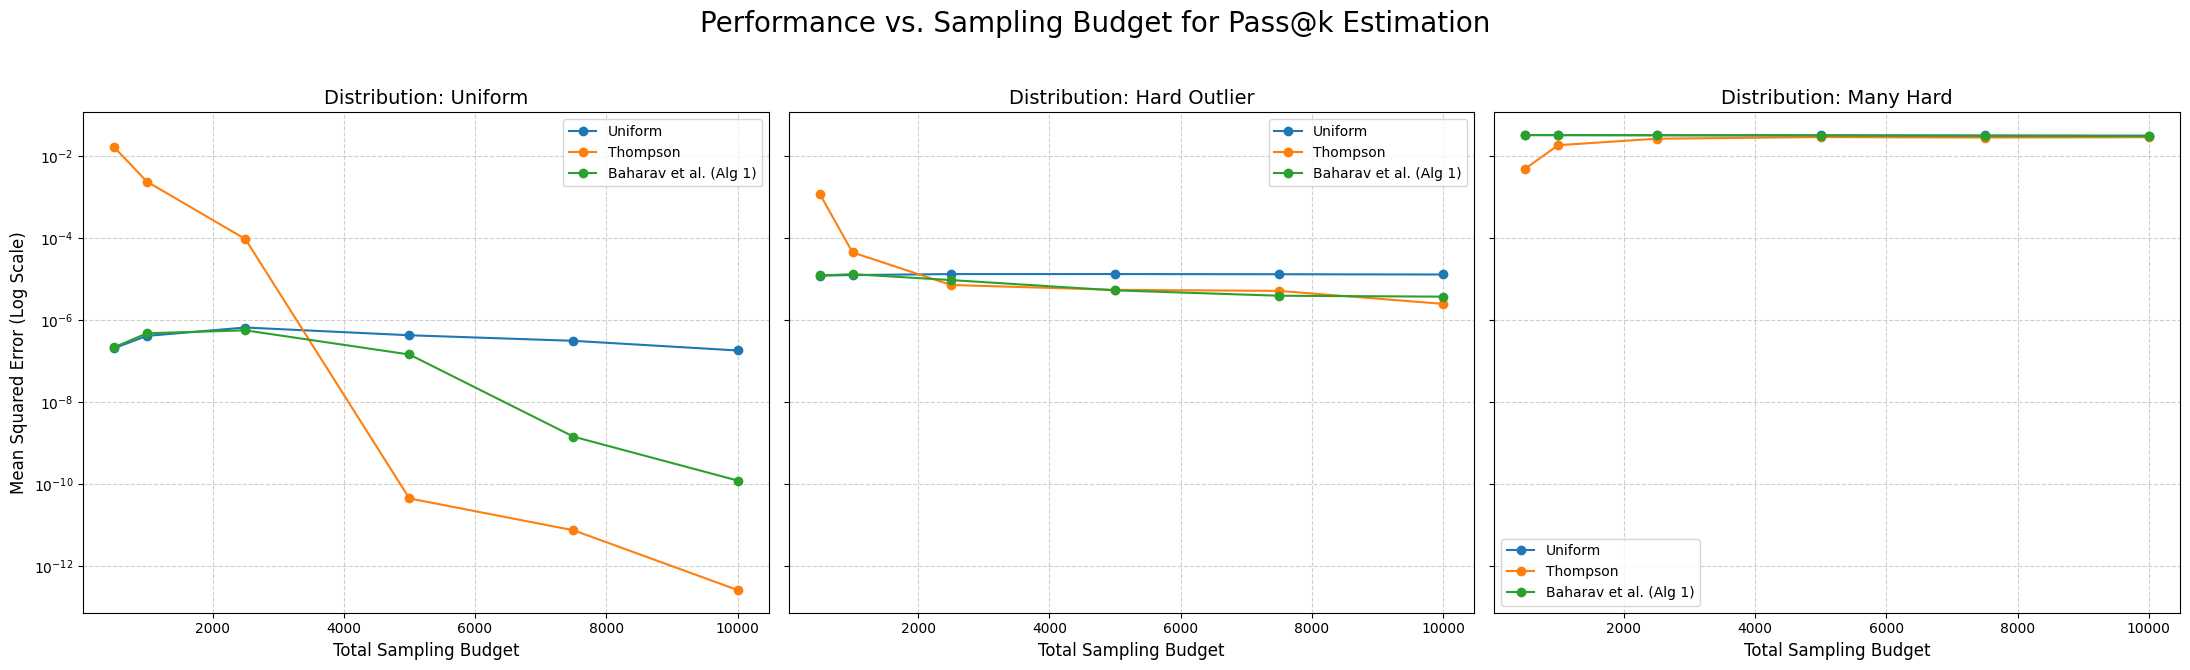

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd

# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [500, 1000, 2500, 5000, 7500, 10000]
K_VALUE = 10000      # The 'k' in pass@k we want to estimate
NUM_SIMULATION_RUNS = 50 # Number of times to run for stable results

# --- Problem Set Generation ---

def generate_problem_set(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['uniform', 'hard_outlier', 'many_hard']
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }

    results = {dist: {name: {budget: [] for budget in BUDGET_LEVELS} for name in strategies} for dist in distributions}

    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")

    for i in range(NUM_SIMULATION_RUNS):
        if (i+1) % 10 == 0:
            print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set(dist_type)
            true_pk = get_true_pass_k(problem_set, K_VALUE)

            for budget in BUDGET_LEVELS:
                for name, func in strategies.items():
                    s, a = func(problem_set, budget, K_VALUE)
                    est_pk = estimate_pass_k(s, a, K_VALUE)
                    mse = (est_pk - true_pk)**2
                    results[dist_type][name][budget].append(mse)

    avg_results = {dist: {name: {budget: np.mean(mses) for budget, mses in budgets.items()}
                           for name, budgets in strats.items()}
                   for dist, strats in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(22, 7), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('Total Sampling Budget', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Joshua's modification that makes this run on real data

In [2]:
import sys
import os
import src.analyze as analyze 
import src.stats_utils as stats_utils
import src.mixtures as mixtures
import src.better_optimiation as bopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import src.EM as EM
from src.EM import compute_estimate, compute_estimate_stable, compute_p_at_ks, compute_estimates_better_mixture
import src.better_em as BEM
import heapq
import src.bem_geometric as bemg
from src.bem_geometric import compute_estimates_better_three_param_geometric, compute_estimates_three_param
#get data for the number of math problems solved
data = analyze.create_or_load_large_language_monkeys_pythia_math_pass_at_k_df()

#this tells us whether each attempt was a success or failure -- I don't think it adds any 
#value given that the attempts were independent
individual_data = analyze.create_or_load_large_language_monkeys_pythia_math_individual_outcomes_df()

/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/analyze.py:250: SyntaxWarning: invalid escape sequence '\i'
  """
/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/analyze.py:292: SyntaxWarning: invalid escape sequence '\i'
  """
/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_pass_at_k.parquet with shape:  (90496, 7)
Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_individual_outcomes.parquet with shape:  (8960000, 5)


In [13]:
MODEL = 'Pythia 6.9B'

In [15]:
data_model.head()

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score
64640,0.0154,1,0,Pythia 6.9B,MATH,-4.173388,4.173388
64641,0.0076,1,1,Pythia 6.9B,MATH,-4.879607,4.879607
64642,0.0109,1,2,Pythia 6.9B,MATH,-4.518992,4.518992
64643,0.0003,1,3,Pythia 6.9B,MATH,-8.111728,8.111728
64644,0.2319,1,4,Pythia 6.9B,MATH,-1.461449,1.461449


In [16]:
data_model = data[data['Model'] == MODEL]
problem_success_rates = data_model[data_model['Scaling Parameter'] == 1]

In [26]:
data_model.groupby('Scaling Parameter')['Score'].mean()

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
        6333,  6667,  7000,  7333,  7667,  8000,  8500,  9000,  9500, 10000], dtype='int64', name='Scaling Parameter', length=101)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd

# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [500, 1000, 2500, 5000, 7500, 10000]
K_VALUE = 10000      # The 'k' in pass@k we want to estimate
NUM_SIMULATION_RUNS = 50 # Number of times to run for stable results

# --- Problem Set Generation ---

def generate_problem_set(distribution_type: str, problem_success_rates):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])
    
    elif distribution_type == 'real':
        return problem_success_rates['Score']
        

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k(problems, k, dataset = None):
    """Calculates the true pass@k from the ground truth probabilities."""

    if dataset is None:
        return k, np.mean(1 - (1 - problems)**k)
    else:
        groups = data_model.groupby('Scaling Parameter')['Score'].mean()
        return groups.index, groups.values
        

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['real']
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }

    results = {dist: {name: {budget: [] for budget in BUDGET_LEVELS} for name in strategies} for dist in distributions}

    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")

    for i in range(NUM_SIMULATION_RUNS):
        if (i+1) % 10 == 0:
            print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set(dist_type, problem_success_rates)
            k, true_pk = get_true_pass_k(problem_set, K_VALUE, data_model)

            for budget in BUDGET_LEVELS:
                for name, func in strategies.items():
                    s, a = func(problem_set, budget, K_VALUE)
                    est_pk = np.array([estimate_pass_k(s, a, k_dummy) for k_dummy in k])
                    mse = ((est_pk - true_pk)**2).sum()
                    results[dist_type][name][budget].append(mse)

    avg_results = {dist: {name: {budget: np.mean(mses) for budget, mses in budgets.items()}
                           for name, budgets in strats.items()}
                   for dist, strats in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(22, 7), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('Total Sampling Budget', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 50 simulations for each distribution and budget...


KeyError: 0